### **IMPORT LIBRARY**


In [1]:
# Import library
import numpy as np
import torch.nn as nn, torch
from scipy.signal import savgol_filter
from scipy import sparse
import matplotlib.pyplot as plt
import pickle
import sys

# Adding path to py files
sys.path.append('../src')

# Importing the custom quantization module
from CustomQuantization import CustomQuantization as quant
from convertQuantizeModel import convertDenseLayer
from QuantLinearLayer import QuantLinear
from utils_tensor import *

### **LOADING WEIGHTS**


In [2]:
# Weights file names
bert_weight_name = 'bert-base-uncased'

# Loading bert model
with open(f'../saved/weights_only/{bert_weight_name}_weights.pkl','rb') as file:
    bert_weights_dict = pickle.load(file)

weight = bert_weights_dict['encoder.layer.9.attention.self.value.weight']

### **QUANTIZATION MODULE**


In [3]:
QuantizationObject = quant()

weight = torch.Tensor(weight)

# Finding suitable weight range 
QuantizationObject.extractRange(weight, save_plot=False, plot_path='./plots/Sample.png')

# Applying quantization
QuantizationObject.proceedQuantization(weight)

Local minimum:  tensor(-0.1981)  Local max:  tensor(0.2093) Points:  500


Ratio of first region range coverage: tensor(0.3032) Region of selection index:  0
Ratio of second region range coverage: tensor(0.2028) Region of selection index:  1
First Region Range:  (tensor(-0.1467), tensor(-0.0234))
Second Region Range (tensor(0.0068), tensor(0.0893))


### **DUMMY MODEL CONVERSION TESTING**


In [4]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(1000, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x    
    
# Dummy Model
SimpleNN = NNModel()
SimpleNN

NNModel(
  (fc1): Linear(in_features=1000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
QuantNN = convertDenseLayer(SimpleNN, requires_plot=False)
QuantNN

Layer Name: fc1
Local minimum:  tensor(-0.0316, grad_fn=<MinBackward1>)  Local max:  tensor(0.0316, grad_fn=<MaxBackward1>) Points:  500
Ratio of first region range coverage: tensor(0.1406) Region of selection index:  8
Ratio of second region range coverage: tensor(0.1365) Region of selection index:  0
First Region Range:  (tensor(-0.0316), tensor(-0.0230))
Second Region Range (tensor(0.0174), tensor(0.0263))
Layer Name: fc2
Local minimum:  tensor(-0.0913, grad_fn=<MinBackward1>)  Local max:  tensor(0.0913, grad_fn=<MaxBackward1>) Points:  500
Ratio of first region range coverage: tensor(0.3635) Region of selection index:  2
Ratio of second region range coverage: tensor(0.2008) Region of selection index:  0
First Region Range:  (tensor(-0.0913), tensor(-0.0547))
Second Region Range (tensor(0.0247), tensor(0.0909))
Layer Name: fc3
Local minimum:  tensor(-0.1088, grad_fn=<MinBackward1>)  Local max:  tensor(0.1091, grad_fn=<MaxBackward1>) Points:  500
Ratio of first region range coverage:

NNModel(
  (fc1): QuantLinear()
  (fc2): QuantLinear()
  (fc3): QuantLinear()
)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Define max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
CNNmodel = SimpleCNN()
CNNmodel


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)

In [7]:
Qunat_model = convertDenseLayer(CNNmodel)
Qunat_model

Layer Name: fc1
Local minimum:  -0.022097081  Local max:  0.022096813 Points:  44
Ratio of first region range coverage: 0.4523809523809524 Region of selection index:  1
Ratio of second region range coverage: 0.3333333333333333 Region of selection index:  0
First Region Range:  (-0.022097080945968628, -0.00803538750518452)
Second Region Range (0.0010042725638909795, 0.020087999376383697)
Layer Name: fc2
Local minimum:  -0.04419101  Local max:  0.04417848 Points:  88
Ratio of first region range coverage: 0.2558139534883721 Region of selection index:  3
Ratio of second region range coverage: 0.22093023255813954 Region of selection index:  0
First Region Range:  (-0.04419101029634476, -0.025111234323544934)
Second Region Range (0.02007770876992833, 0.0421700809489597)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantLinear()
  (fc2): QuantLinear()
  (relu): ReLU()
)

### **PYTORCH TENSOR FUNCTION TESTING**


In [1]:
import sys
import torch, torchaudio
import matplotlib.pyplot as plt

sys.path.append('../src')
from utils import *

Local minimum:  tensor(0.0716)  Local max:  tensor(0.8518) Points:  500


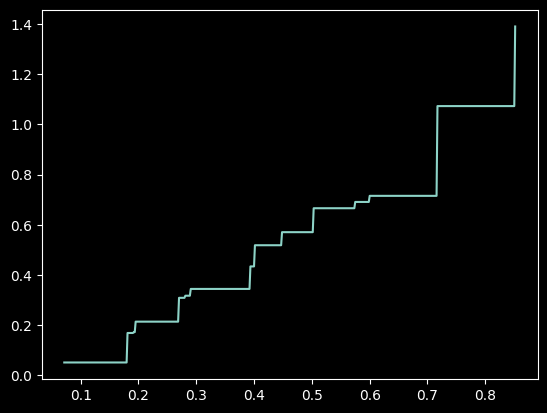

In [2]:

X = torch.rand((1, 5))
Weight = torch.rand((3, 5))
Y = Weight@X.T

Mag, Loss = findLossPerThreshold(X, Weight, Y, lploss)

plt.plot(Mag.numpy(), Loss.numpy(),)





In [12]:
A = Loss[:15]
B = Mag[:15]
C = torch.tensor([False,True,True,True,False,True,True,True,True,False,True,True,True,True,True])

Regions = findRanges(C, A, B)
findLargestRegion(Regions, B[-1] - B[0])



Ratio of first region range coverage: tensor(0.2857) Region of selection index:  2
Ratio of second region range coverage: tensor(0.2143) Region of selection index:  1


[(tensor([0.0508, 0.0508, 0.0508, 0.0508, 0.0508]),
  tensor([0.0872, 0.0888, 0.0904, 0.0919, 0.0935])),
 (tensor([0.0508, 0.0508, 0.0508, 0.0508]),
  tensor([0.0794, 0.0810, 0.0825, 0.0841]))]

In [1]:
Array = torch.randint(0, 2, (5,5))
torch.sparse.to_sparse_semi_structured(Array)

NameError: name 'torch' is not defined